# my super first notebook 

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

## def des variables 

In [17]:
N = 256 # number of synaptic input 
trials = 306 # number of trials 
K = 10 # number of classes 
seed = 1973

p_0 = 0.1 #average firing rate
p1 = .01 # average firing probability
B_theta = 0.51 # largeur des probas

h = 0.2 # hazard rate per trial

fig_width = 10
phi = np.sqrt(5)/2 + 1/2
figsize = (fig_width, fig_width/phi)

verb = True

## generetion de datas

In [18]:
class data : 

    # ... Of Y 
    
    def vm(self, theta_0, B_theta) :
        p = torch.exp(torch.cos(torch.linspace(0, 2*np.pi, N) - theta_0) / B_theta**2)
        p /= p.mean()
        p *= p_0
        return p 
    
    def stack(self):
        p = torch.zeros((N, K))
        for k in range(K) :
            theta_0 = 2 * torch.pi * (k + 1/2) / K
            p[:,k] = self.vm(theta_0 = theta_0, B_theta = B_theta)  
        return p
    
    def plot_proba(self, p, ms='-', alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
        cmap = plt.get_cmap("plasma")
        if not p is None:
            for k in range(K):
                ax.step(torch.arange(N), p[:, k], ms, alpha=alpha, color=cmap(k/K))
        ax.set_ylabel('probability of firing for each address')
        ax.set_xlabel('input address')
        ax.set_xlim(0, N)
        return fig, ax

    # ... Of X
    def generative_model(self, p, T=None, do_poisson=False) :
        if T is None : 
            if do_poisson:
                # use a Poisson distribution to define variable lengths
                T = trials 
                b = torch.rand((T,N)) < p[None, :]
                b = torch.poisson(b)
                #T = torch.rand(trials)
                #T = torch.poisson(T)
                # doesn't work because torch.rand must be a tuple of ints, not Tensor, d'ailleurs en NP
            else:
                T = trials
                b = torch.rand((T,N)) < p[None, :] # on génère des b qui sont inférieurs à la probabilité. Si p ~ 0, b = 0, si p > 0, b > 0    
                b = b.long()
            return b
    
    def get_data(self, p) :
        b = self.generative_model(p.mean() * torch.ones(N)) # on appelle la fonction generative model, qui genère des b si p>0 --> donne des spikes un peu partout parce que p = p.means donc valeure moyenne dopnc 50/50 < à rand
        order = torch.arange(K)
        #torch.randperm(order)
        for k in order:
            b = torch.vstack((b, self.generative_model(p[:,k]))) # on prend b avec des spikes 50/50 et on rappelle generative_modele, donc il refait le truc de generation des b que si p>0, mais cette fois p varie across les neurones donc b ne sera plus aléatoire, il sera ok quand p>0 et 0 quand p~0. On fait ça pour chaque K et on obtient la super figure. Par contre, j'ai du mal à comprendre pourquoi on a besoin de le faire avec p_mean avant, j'ai vu que si on l'enlevait ça ne marchait plus mais idkwhy 
            #b = self.generative_model(p[:,k])
        return b
    
    def plot_raster(self, b, alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
        ax.pcolormesh(b.T)
        ax.set_xlabel('time (bin number)')
        ax.set_ylabel('input address')
        return fig, ax


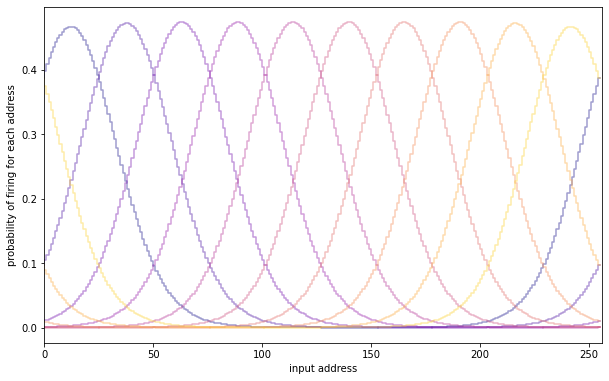

In [19]:
d = data()        
p_true = d.stack() 
d.plot_proba(p_true)

plt.show()

### visu

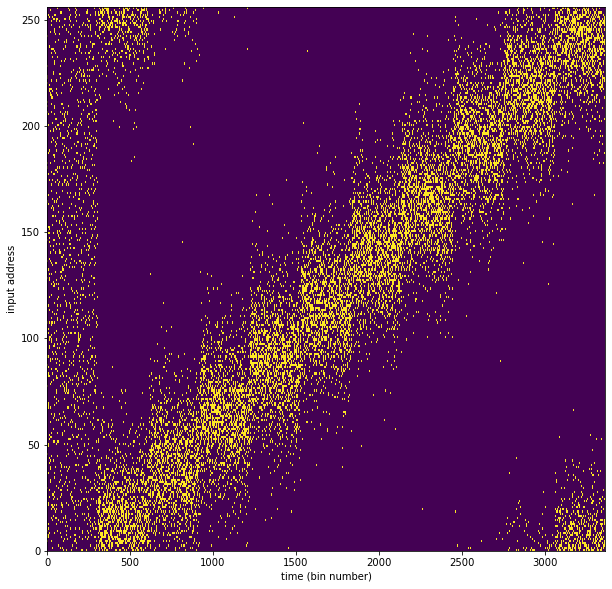

In [20]:
b = d.get_data(p_true)
d.plot_raster(b)
plt.show()

In [21]:
b.shape

torch.Size([3366, 256])

On vient de définir des fonctions pour __générer nos X et nos Y__.

Les X correspondent à __l'activité de 256 neurones à un temps T,__ au cours de différents trials. A chaque trial est présenté une orientation, entrainant une certaine activité neuronale. __Les Y correspondent à l'activité neuronale induite par la présentation d'une orientation.__ 

Pour générer les données, on commence par définir la __probabilité de firing de chaque neurone, pour chaque orientation (nos Y).__ A partir de ces probabilités, on génère __l'activité neuronale au cours de différents trials (nos X)__ de sorte à ce que, à chaque trial, l'activité neuronale feat avec les probabilités de firing des neurones déterminées en Y.

Le but de ce notebook sera de __tester différentes méthodes__ pour déterminer, __à partir de l'activité neuronale, l'orientation présentée.__ 
1/ detection : sans apprentissage, en connaissant les proba de firing des neurones pour les différentes orientations 
2/ apprentissage suppervisé : en connaissant les probas de firing des neurones pour chaque orientation, apprentissage de p_hat (initialisé aléatoirement) selon regression logistique 
3/ apprentissage no

## detection 

In [22]:
class OnlineBinaryDetection(data) :
        
    # la surprise est très importante, elle se base sur les probabilités de firing des neurones pour déterminer si l'occurence d'un spike est surprenante ou non.
    # b peut prendre deux valeurs : 0 ou 1 (spike ou pas spike), en le multipliant par la probabilité de firing, on quantifie la surprise d'occurence ou d'absence du spike
    # si b = 1 alors b*log2p + 1-b*log2 1-p = log2p
    # si b = 0 alors b*log2p + 1-b*log2 1-p = log2 1-p
    # si p de voir apparaitre un spike est forte alors log2p est faible, alors que log2 1-p est forte, la surprise est donc importante si b est différent de ce à quoi on s'attend 
    def surprise(self, b, p) :
        return -(b[:, :, None]*torch.log2(p[None, :, :]) + (1-b[:, :, None])*torch.log2(1-p[None, :, :])).sum(axis=1)
    
    def get_surprise(self, b, p) :
        T, N = b.shape
        N_, K = p.shape
        
        # a chaque trial on présente une orientation donc à chaque trial on devrait avoir peu de surprise pour un K mais plus de surprise pour les autres K  
        S = torch.zeros((T, K)) # pourquoi dim 2 = K ? 
        S[-1, :] = self.surprise(p_0 * torch.ones((1, N)), p) 
        
        for t in range(T) :
            S[t, :] = (1- h) * S[t-1, :] + h * self.surprise(b[t,:][None,:], p)
            #S[t, :] = self.surprise(b[t,:][None,:], p) # si on met cette ligne, les surprises sont bcp plus larges et se supperposent, need explanation about what is happened au dessus 
        return S
    
    def get_proba(self, S) :
        two = torch.Tensor([2])
        P = torch.exp(-torch.log(two) * S)
        P /= P.sum(axis = 1)[:, None]
        return P

    def plot_surprise(self, S,  xlabel='trials', ylabel='surprise',alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
        cmap = plt.get_cmap("plasma")
        ax.plot(S, alpha=alpha)
        ax.set_xlabel('trials')
        ax.set_ylabel('surprise')
        return fig, ax
    
    def plot_proba(self, P, xlabel='trials', ylabel='proba',alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
        ax.plot(P, alpha=alpha)
        ax.set_xlabel('trials')
        ax.set_ylabel('proba')
        return fig, ax
    
    

(<Figure size 720x444.984 with 1 Axes>,
 <AxesSubplot:xlabel='trials', ylabel='surprise'>)

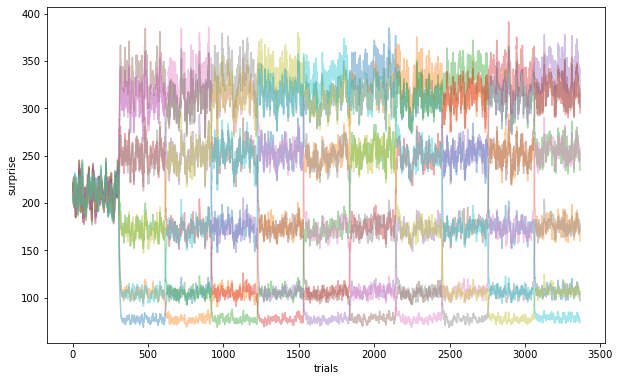

In [23]:
obd = OnlineBinaryDetection()
S = obd.get_surprise(b, p_true)
obd.plot_surprise(S)
# je voudrais que les couleurs correspondent aux probas générées 

(<Figure size 720x444.984 with 1 Axes>,
 <AxesSubplot:xlabel='trials', ylabel='proba'>)

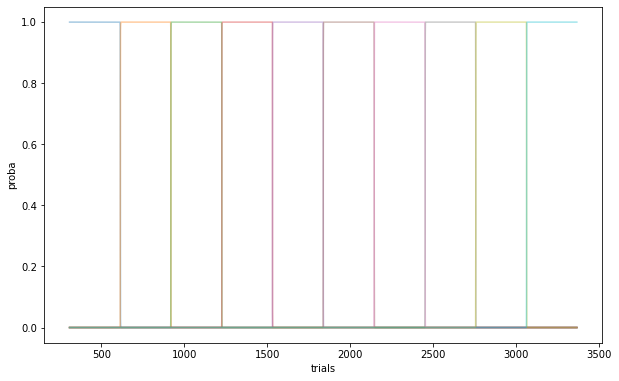

In [24]:
P = obd.get_proba(S)
obd.plot_proba(P)

In [25]:
b.shape

torch.Size([3366, 256])

## supervised learning 

## unsupervised learning 
